### Objective

* Detect event-driven shocks, measure how they propagate across companies, and output a shock strength + propagation score that later feeds volatility models.

In [8]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.api import VAR

plt.style.use("seaborn-v0_8")
np.random.seed(42)


### phase 1 config
* SECTOR: Semiconductors
* TICKERS: NVDA, AMD, TSM, INTC
* OPTIONS DATA: YES
* TIMEFRAME: Daily returns (Phase 1)
* FOCUS: Shock → propagation → systemic importance

In [5]:
SECTOR = "Semiconductors"

tickers = ["NVDA", "AMD", "TSM", "INTC"]


In [10]:
start_date = "2018-01-01"
end_date = None  # up to today

data = yf.download(
    tickers,
    start=start_date,
    end=end_date,
    progress=False
)

prices = data["Close"].dropna()
prices.tail()


Ticker,AMD,INTC,NVDA,TSM
Date,,,,
2025-12-19,213.429993,36.820000,180.990005,288.950012
2025-12-22,214.949997,36.369999,183.690002,293.279999
2025-12-23,214.899994,36.349998,189.210007,296.950012
2025-12-24,215.039993,36.160000,188.610001,298.799988
2025-12-26,214.990005,36.200001,190.529999,302.839996


In [11]:
returns = prices.pct_change().dropna()
returns.head()


Ticker,AMD,INTC,NVDA,TSM
Date,,,,
2018-01-03,0.051913,-0.033938,0.065814,0.016821
2018-01-04,0.049351,-0.018339,0.005271,-0.005274
2018-01-05,-0.019802,0.006977,0.008474,0.023379
2018-01-08,0.033670,0.000000,0.030641,-0.000471
2018-01-09,-0.037459,-0.025033,-0.000270,-0.006126


In [12]:
WINDOW = 20
Z_THRESHOLD = 2.5

z_scores = (
    returns
    .rolling(WINDOW)
    .apply(lambda x: (x.iloc[-1] - x.mean()) / x.std(), raw=False)
)

shock_events = (z_scores.abs() > Z_THRESHOLD)
shock_events.tail()


Ticker,AMD,INTC,NVDA,TSM
Date,,,,
2025-12-19,False,False,False,False
2025-12-22,False,False,False,False
2025-12-23,False,False,False,False
2025-12-24,False,False,False,False
2025-12-26,False,False,False,False


In [13]:
# granger casuality
MAX_LAG = 5
edges = []

for source in tickers:
    for target in tickers:
        if source == target:
            continue

        df = returns[[target, source]].dropna()

        try:
            tests = grangercausalitytests(
                df,
                maxlag=MAX_LAG,
                verbose=False
            )

            pvals = [
                tests[i + 1][0]["ssr_ftest"][1]
                for i in range(MAX_LAG)
            ]

            min_p = min(pvals)

            if min_p < 0.05:
                edges.append((source, target, 1 - min_p))

        except Exception:
            pass


C:\Users\taran\miniconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\taran\miniconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\taran\miniconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\taran\miniconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\taran\miniconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\taran\miniconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since function

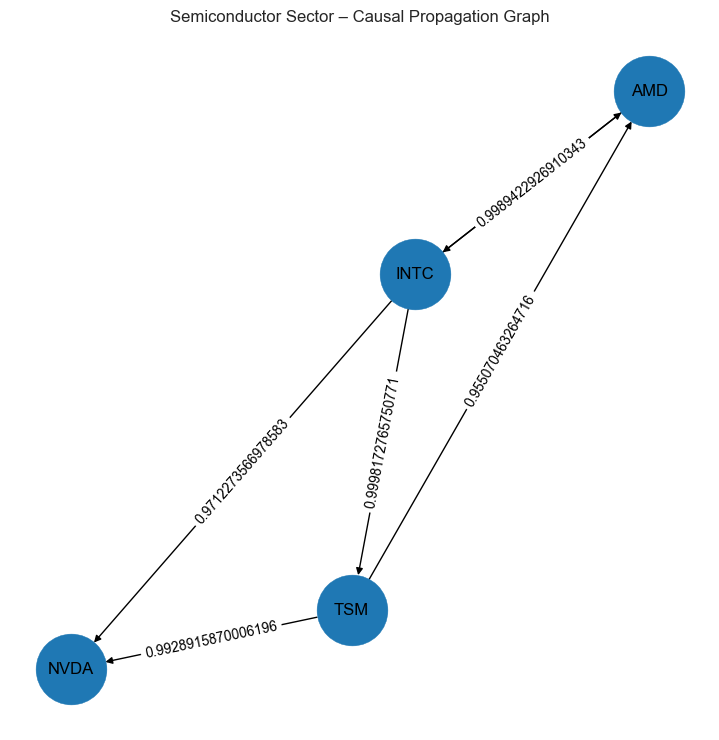

In [14]:
# sector causal graph
G = nx.DiGraph()

for src, tgt, w in edges:
    G.add_edge(src, tgt, weight=w)

plt.figure(figsize=(7,7))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_size=2600)
nx.draw_networkx_edge_labels(
    G,
    pos,
    edge_labels=nx.get_edge_attributes(G, "weight")
)
plt.title("Semiconductor Sector – Causal Propagation Graph")
plt.show()


In [15]:
def propagation_score(graph, source):
    distances = nx.single_source_shortest_path_length(graph, source)
    return sum(1 / (d + 1) for d in distances.values())

phase1_output = pd.DataFrame({
    "ticker": tickers,
    "propagation_score": [
        propagation_score(G, t) for t in tickers
    ]
}).sort_values("propagation_score", ascending=False)

phase1_output


,ticker,propagation_score
3,INTC,2.500000
2,TSM,2.333333
1,AMD,2.166667
0,NVDA,1.000000
